In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [49]:
class Individual:

  '''
  This class represent an individual in the population for the GA
  
  Attributes:
    - path: a list that is used for storing the direction of the path
    - fitness: a variable used for saving the value of the fitness of the individual
  '''

  def __init__(self):
    '''
    Constructor of the Individual class: path is initialized as an empty list
                                         while fitness is initialized as 0 
    '''
    self.path = []
    self.fitness = 0
    self.number_of_cp_reached = 0

  def getPath(self):
    # this method is used to retrieve the path of the individual 
    return self.path

  def getFitness(self):
    # this method is used to retrieve the fitness of the individual
    return self.fitness

  def compass(self,current_point,control_point):
    
    if current_point[0] >= control_point[0] and current_point[1] >= control_point[1]:
      direction1 = 0
      direction2 = 1
    elif current_point[0] >= control_point[0] and current_point[1] <= control_point[1]:
      direction1 = 1
      direction2 = 2
    elif current_point[0] <= control_point[0] and current_point[1] <= control_point[1]:
      direction1 = 2
      direction2 = 3
    elif current_point[0] <= control_point[0] and current_point[1] >= control_point[1]:
      direction1 = 0
      direction2 = 3


    return direction1, direction2

  def __repr__(self):
        return "(Path: " + str(self.path) + ", fitness: " + str(self.fitness) + ", number_of_cp_reached: "+ str(self.number_of_cp_reached) + ")"

In [84]:
x = random.choice([moves[0],moves[3]])
x

[0, -1]

In [14]:
class Map:

  '''
  This class is used to create the map where the Orieentiring take place:
  it is a mxn array (m and n are given as parameter) where a certain number of
  obstacles and control points are placed.

  Attributes:
    - rows: the number of rows of the map (the m dimension)
    - colums: the numbers of the map (the n dimension)
    - number_of_obstacles: the number of obstacles that will appear on the map
    - number_of_cp: number of control points that will appear on the map
    - cp_list: a list containing all the coordinates of the control points. 
               Initially contains the start point at (0,0)
  '''

  def __init__(self, rows, columns, number_of_obstacles, number_of_cp):

    '''
    The constructor of the map: lenght and height represent the dimension of the map (array)
    while number_of_obstacles and number_of_cp represent the number of obstacles and the number
    of control points that will be placed on the map, respectively.
    '''

    self.rows = rows
    self.columns = columns
    self.number_of_obstacles = number_of_obstacles
    self.number_of_cp = number_of_cp
    self.cp_list = []

  def create_map(self):

    '''
    This method is used to fill the array: the 'walkable ground' will be the cells that contains 0, the obstacle
    will be the cells containing 1 and the control points will be the cells containg 2, including the start and
    ending points. 
    '''

    map = np.zeros((self.rows, self.columns)) #initially, we create the array with all 0s

    for i in range(self.number_of_obstacles): # iterate over the number of obstacles 

      #randomically, create the coordinates where to put the obstacle
      x_obstacle = np.random.randint(0,self.rows)
      y_obstacle = np.random.randint(0,self.columns)
      #print('Posizione ostacolo: {0}, {1}'.format(x_ostacolo,y_ostacolo))

      #check if the coordinate corresponds with a control point, the start or the end
      if map[x_obstacle][y_obstacle] == 2:
        #if true, do not place the obstacle
        continue
      else:
        #else, put the obstacle
        map[x_obstacle][y_obstacle] = 1
      
      #next, place the control point, if any remain to be placed
      if self.number_of_cp != 0:
        
        #randomically, create the coordinates where to put the control point
        x_cp = np.random.randint(0,self.rows)
        y_cp = np.random.randint(0,self.columns)
        
        #check if the control point is over an obstacle
        if map[x_cp][y_cp] == 1:
          #if true, do not put the control point
          continue
        else: 
          map[x_cp][y_cp] = 2 # put the control point
          self.cp_list.append([x_cp,y_cp]) # add the coordinate to the list of all control points
          self.number_of_cp -= 1 # reduce the number of control points

    #self.cp_list.append([self.lenght-1,self.height-1]) # in the end, add the arrival point to the list of control points
    self.cp_list.sort()
    return map, self.cp_list # return the array and the list
    

  def getControlPointList(self):

    # this method is used for obtain the list of control points
    return self.cp_list

  def visualizeMap(self,map):

    '''
    this method is used for plotting the map
    '''
    # set the dimension of the plot
    plt.figure(figsize=(12,12))

    #use a heatmap for plotting, so the same value will have the same color
    ax = sns.heatmap(map, cbar = False, cmap = sns.color_palette("coolwarm", 12),linewidth = 1)

    # get the x and y coordinate for each point, and sum 0.5, so the line will start at the centre of the square
    x = [self.cp_list[i][1] + 0.5 for i in range(len(self.cp_list))]
    y = [self.cp_list[i][0] + 0.5 for i in range(len(self.cp_list))]

    #plot the lines
    plt.plot(x, y, 'ro-')

    #add text near the point
    plt.text(x[0] - 0.15, y[0] - 0.15, 'Start')
    for i in range(1,len(x)-1):
      plt.text(x[i] + 0.15, y[i] + 0.15, str(i))
    plt.text(x[-1] - 0.20, y[-1] - 0.20, 'End')

    ax.invert_yaxis()

    plt.ylim(0,self.rows)
    plt.xlim(0,self.columns)

    #show the plot
    plt.show()


7


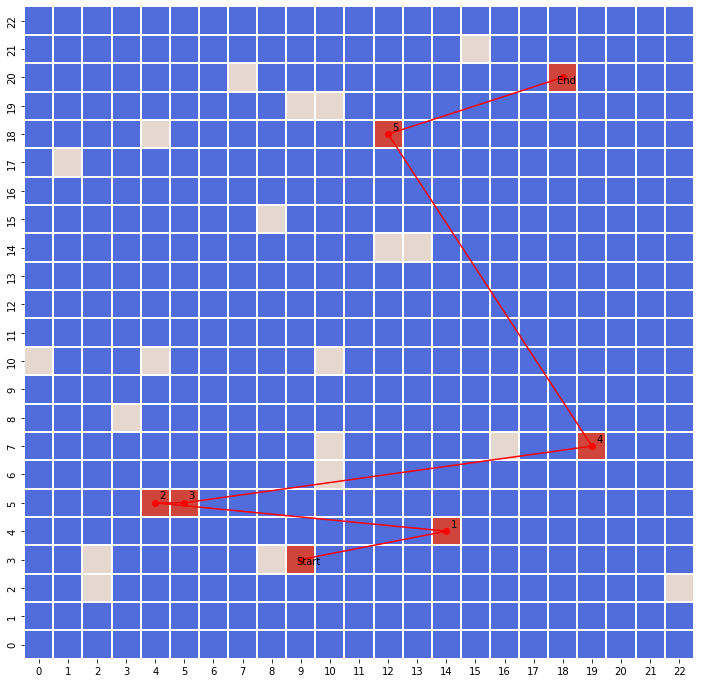

In [121]:
map = Map(23,23,20,7)
print(map.number_of_cp)
mappa, lanterne = map.create_map()
map.visualizeMap(mappa)

In [122]:
cp_list = map.getControlPointList()
cp_list

[[3, 9], [4, 14], [5, 4], [5, 5], [7, 19], [18, 12], [20, 18]]

In [ ]:
def avoid_obstacle(current_point, movement):

  pass

In [ ]:
reached = False
blocked = False
cp_list = map.getControlPointList()
moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
ind = Individual()

current_point = cp_list[0]
print('### -- Parto da --> {0}, devo andare a --> {1}-- ###'.format(current_point,cp_list[1]))
steps = 0
for i in range(1, len(cp_list)):
  reached = False
  while not reached:

    if steps % 5 == 0:
      print('### -- Trovo direzione -- ###')
      d1,d2 = ind.compass(current_point, map.getControlPointList()[i])
      movement = random.choice([moves[d1],moves[d2]])
    else:
      movement = random.choice(moves)
    
    ind.path.append(moves.index(movement))
    print('### -- Mi muovo verso la direzione: {0} -- ###'.format(movement))
    steps += 1
    current_point = [current_point[0] + movement[0], current_point[1] + movement[1]]

    print('### -- Sono arrivato in -- > {0}, devo andare a --> {1} -- ###'.format(current_point,cp_list[i]))

    if current_point[0] < 0 or current_point[1] < 0 or current_point[0] > map.rows or current_point[1] > map.columns:
      print('### -- Sono fuori dalla mappa --- ###')
      blocked = True
      break

    if mappa[current_point[0]][current_point[1]] == 1:

      current_point = [current_point[0] - movement[0], current_point[1] - movement[1]]

      remain_moves = moves.remove(movement)

      for elements in remain_moves:

         point = [current_point[0] + elements[0], current_point[1] + elements[1]]

         if mappa[point[0]][point[1]] == 1:
           blocked = True
           break
         else:
           current_point = point
           break

        


      print('### -- Sono su un OSTACOLO, ahi -- ###')
      blocked = True
      break

    if current_point[0] == cp_list[i][0] and current_point[1] == cp_list[i][1]:
      print('### -- Ho trovato la LANTERNA {0}, yeah -- ##'.format(i))
      ind.number_of_cp_reached = i
      reached = True
  
  if blocked:
    print('### -- Sono uscito dal ciclo e mi fermo -- ###')
    break

print('Individuo: {0}\nLanterne raggiunte: {1}'.format(ind.path,ind.number_of_cp_reached))